## [BROT (Bilevel Routing on networks with Optimal Transport)](https://github.com/aleable/BROT)

### Contributors:
- Alessandro Lonardi
- Caterina De Bacco

[MIT License, Copyright (c) 2023 Alessandro Lonardi and Caterina De Bacco](https://github.com/aleable/BROT_develop/blob/main/LICENSE)




In [1]:
import nbimporter
import utils
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Usage examples (synthetic experiments on the lattice)

In order to replicate similar results to those proposed in the main paper, you can run BROT in its configurations on the lattice network. This can be simply done with the magic command #1.
In order to compare the solutions of BROT (i.e. those extracted from the bilevel optimization routine) with those computed with the PSGD scheme, or integrating the OT ODEs, one can run the magic commands #2 and #3 respectively. Here below, the dropout probability is set to $q=1$, and can be changed by inputting it as a parameter (```-mask```) of ```main.py```.

In [2]:
# Configuration #1: BROT
print("*** RUNNING BROT ***")
%run main.py -V 0 -Vtime 1 -topol "lattice" -whichinflow "lattice" -sw 0
print("\n")

# Configuration #2: PSGD
print("*** RUNNING PSGD ***")
%run main.py -V 0 -Vtime 1 -topol "lattice" -whichinflow "lattice" -OTex 0 -sw 0
print("\n")

# Configuration #3: OT
print("*** RUNNING OT ***")
%run main.py -V 0 -Vtime 1 -topol "lattice" -whichinflow "lattice" -GDex 0

*** RUNNING BROT ***
[ START ]
============================================================| START
elapsed time = 3.4053030014038086 [s]
elapsed time = 0.0 [s]
============================================================| STOP
[ END ]


*** RUNNING PSGD ***
[ START ]
============================================================| START
elapsed time = 1.3003849983215332 [s]
elapsed time = 1.1363799571990967 [s]
============================================================| STOP
[ END ]


*** RUNNING OT ***
[ START ]
============================================================| START
elapsed time = 0.6291928291320801 [s]
elapsed time = 0.0 [s]
============================================================| STOP
[ END ]


## Plot results

Compiling the following cells you can unpack and plot some preliminary results. Particularly:
1. plot network with fluxes at convergence 
2. plot network with cost difference at convergence
3. plot the optimal transport cost $J$ and the and $\Omega$ at convergence

In [3]:
def unpack_results(OUTPUT_PATH):
    
    from os import listdir
    from os.path import isfile, join
    import pickle as pkl
    
    file_names = [f for f in listdir(OUTPUT_PATH) if isfile(join(OUTPUT_PATH, f))]
    
    for file in file_names:
        if "OTexec_True_GDexec_True" in file:
            if "metadata" in file:
                metadata_BROT = pkl.load(open(OUTPUT_PATH + file, "rb"))
            if "results" in file:
                results_BROT = pkl.load(open(OUTPUT_PATH + file, "rb"))
        if "OTexec_True_GDexec_False" in file:
            if "metadata" in file:
                metadata_OT = pkl.load(open(OUTPUT_PATH + file, "rb"))
            if "results" in file:
                results_OT = pkl.load(open(OUTPUT_PATH + file, "rb"))
        if "OTexec_False_GDexec_True" in file:
            if "metadata_OT" in file:
                metadata_PSGD = pkl.load(open(OUTPUT_PATH + file, "rb"))
            if "results_OT_" in file:
                results_PSGD = pkl.load(open(OUTPUT_PATH + file, "rb"))

    print(results_BROT.keys())
    
    metadata = {"BROT": metadata_BROT, "PSGD": metadata_PSGD, "OT": metadata_OT}
    results = {"BROT": results_BROT, "PSGD": results_PSGD, "OT": results_OT}

    return metadata, results

In [4]:
OUTPUT_PATH = "./data/output/"

# structure of output dicts is {X: metadata(X)} and  {X: results(X)}, with X = BROT, PSGD, OT
metadata, results = unpack_results(OUTPUT_PATH) #utils.unpack_results(OUTPUT_PATH)

dict_keys(['Jevol', 'Omegaevol', 'muevol', 'wevol', 'Fevol', 'psievol', 'network', 'forcing', 'commodities'])


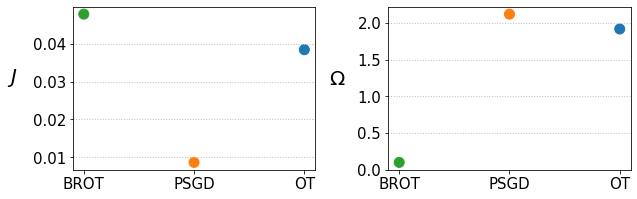

In [5]:
utils.plot_J_Omega(results)

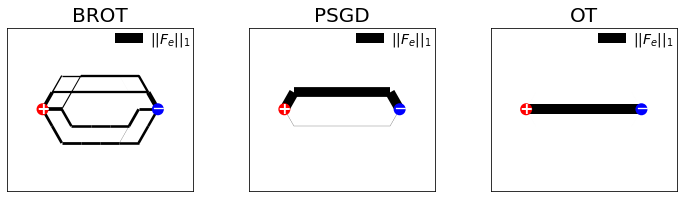

In [6]:
G = results["OT"]["network"] # network
commodities = results["OT"]["commodities"] # OD nodes
norm_S = 0.5 # S is not normalized in input

F_BROT = abs(results["BROT"]["Fevol"]).T[0]/norm_S
F_PSGD = abs(results["PSGD"]["Fevol"]).T[0]/norm_S
F_OT = abs(results["OT"]["Fevol"]).T[0]/norm_S
    
fig, ax = plt.subplots(1,3, figsize=(12,3))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None)

    
utils.plot_network_F(G, commodities, F_BROT, ax[0], title="BROT")
utils.plot_network_F(G, commodities, F_PSGD, ax[1], title="PSGD")
utils.plot_network_F(G, commodities, F_OT, ax[2], title="OT")

# Please note, assymmetric in fluxes is due to the noise added to w.
# To obtain symmetric networks, one should average over a large number of samples.

rho_X := w_X - w_OT, with X = BROT, GD


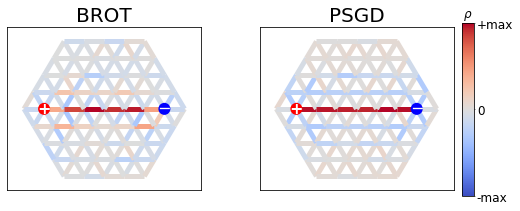

In [7]:
w_OT = abs(results["OT"]["wevol"]).T
norm_w = np.sum(w_OT) # results in code are serialized in OT units
rho_BROT = (abs(results["BROT"]["wevol"]).T - w_OT)/norm_w
rho_PSGD = (abs(results["PSGD"]["wevol"]).T - w_OT)/norm_w
  
fig, ax = plt.subplots(1,2, figsize=(8,3))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None)

utils.plot_network_w(G, commodities, rho_BROT, ax[0], title="BROT")
utils.plot_network_w(G, commodities, rho_PSGD, ax[1], title="PSGD")
utils.plot_colorbar(fig, rho_BROT, ax[1])

# Please note, assymmetric in fluxes is due to the noise added to w
# To obtain symmetric networks, one should average over a large number of samples
# Also, each cost difference is normalized w.r.t to its maximum